# Planners
This shows how a variety of planners work on the same data, with the same prediction model.

In [2]:
from ipp_toolkit.planners.masked_planner import RandomSamplingMaskedPlanner, LawnmowerMaskedPlanner, RandomWalkMaskedPlanner
from ipp_toolkit.planners.diversity_planner import BatchDiversityPlanner
from ipp_toolkit.data.domain_data import SafeForestGMapGreennessRegressionData, SafeForestOrthoGreennessRegressionData, CoralLandsatClassificationData
from ipp_toolkit.predictors.uncertain_predictors import GaussianProcessRegression
from ipp_toolkit.predictors.masked_image_predictor import (
    UncertainMaskedLabeledImagePredictor,
)
from ipp_toolkit.visualization.visualization import visualize_prediction

from ipp_toolkit.config import UNCERTAINTY_KEY

Create a dataset.

In [3]:
data = CoralLandsatClassificationData()

# Random walk
This planner takes a step of the requested length in a random direction. Each candidate step is checked to make sure it is within the valid region.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


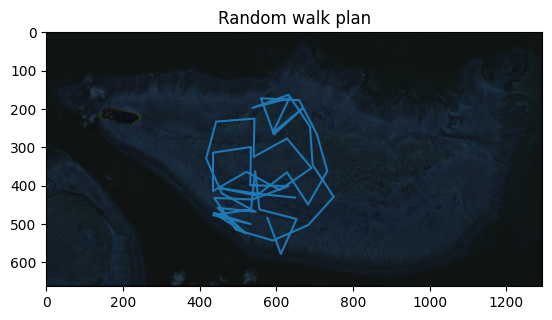

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

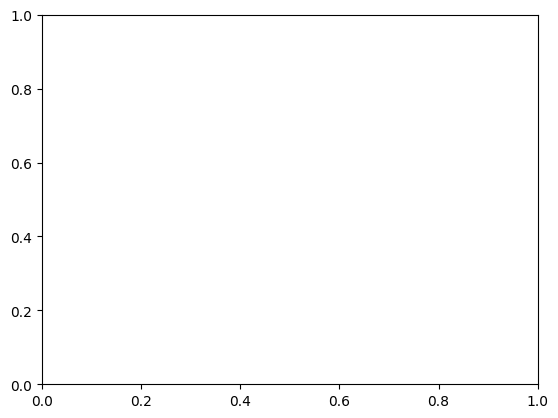

In [5]:
planner = RandomWalkMaskedPlanner(data)
gp = GaussianProcessRegression()
predictor = UncertainMaskedLabeledImagePredictor(
    data, gp, classification_task=data.is_classification_dataset()
)

plan = planner.plan(50, step_size=100, vis=True)
values = data.sample_batch(plan)
predictor.update_model(plan, values)
prediction = predictor.predict_values_and_uncertainty()

visualize_prediction(data, prediction=prediction, predictor=predictor)

# Lawnmower planner
Takes samples on a grid, moving from left to right, top to bottom

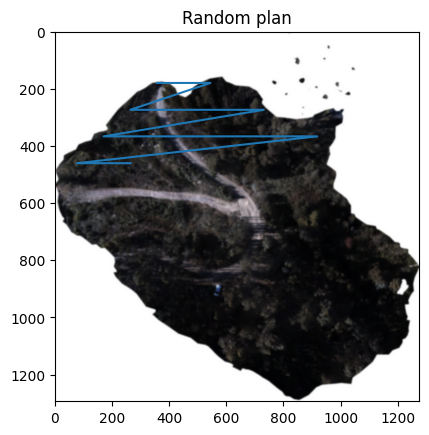

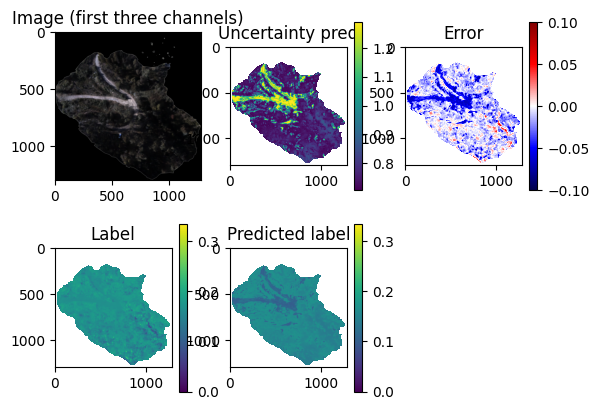

In [ ]:
planner = LawnmowerMaskedPlanner(data, n_total_samples=100)
gp = GaussianProcessRegression()
predictor = UncertainMaskedLabeledImagePredictor(
    data, gp, classification_task=data.is_classification_dataset()
)

plan = planner.plan(20, vis=True)
values = data.sample_batch(plan)
predictor.update_model(plan, values)
prediction = predictor.predict_values_and_uncertainty()

visualize_prediction(data, prediction=prediction, predictor=predictor)

### Random planner
The random planner selects a set of random locations to visit, within the valid region of the image.

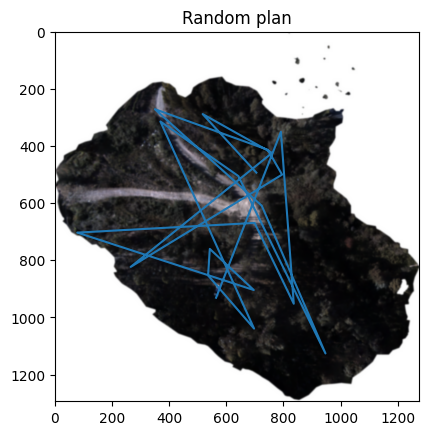

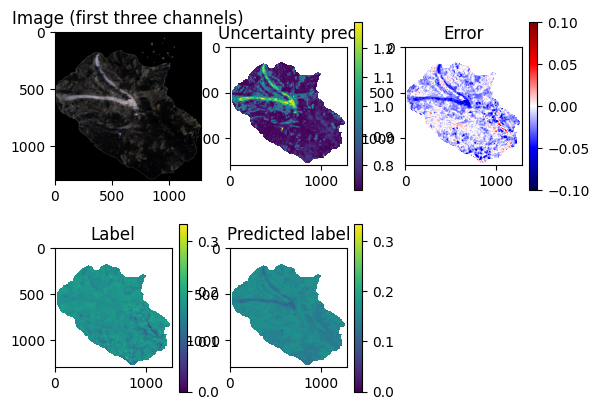

In [ ]:


planner = RandomMaskedPlanner(data)
gp = GaussianProcessRegression()
predictor = UncertainMaskedLabeledImagePredictor(
    data, gp, classification_task=data.is_classification_dataset()
)

plan = planner.plan(20, vis=True)
values = data.sample_batch(plan)
predictor.update_model(plan, values)
prediction = predictor.predict_values_and_uncertainty()

visualize_prediction(data, prediction=prediction, predictor=predictor)


### Diversity-based planner
This planner tries to sample a diverse set of locations at each flight. On flights where it has a metric for which regions are most interesting, it also tries to jointly optimize for visiting those regions.

Flight 1
computing new cluster centers


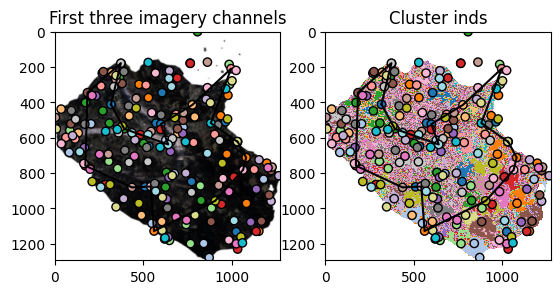

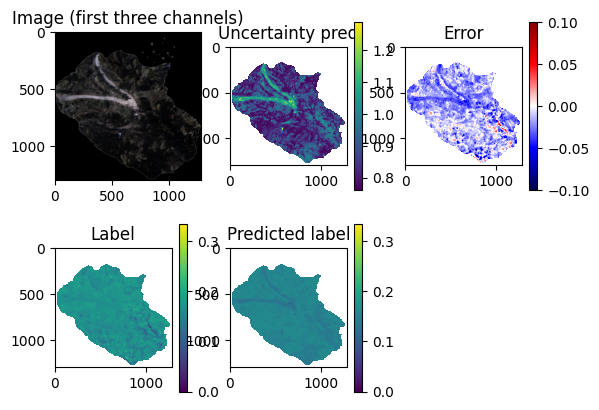

Flight #2


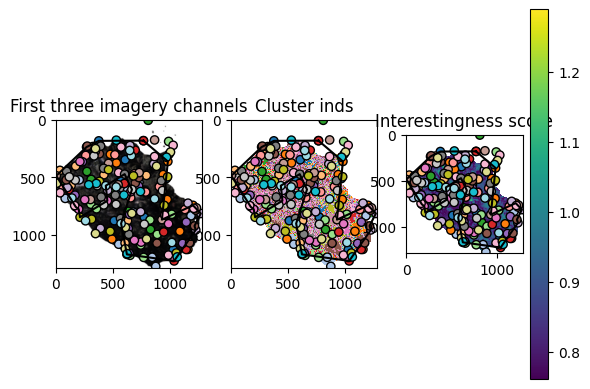

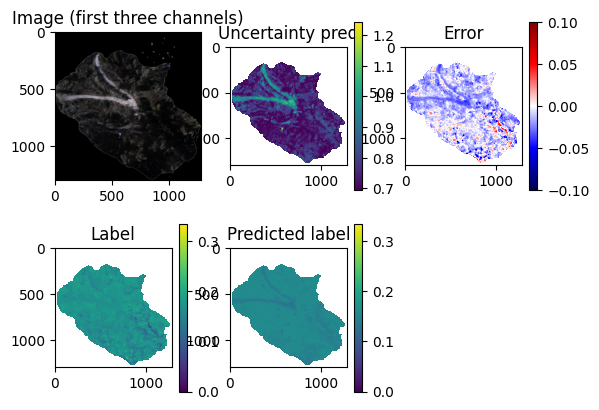

Flight #3


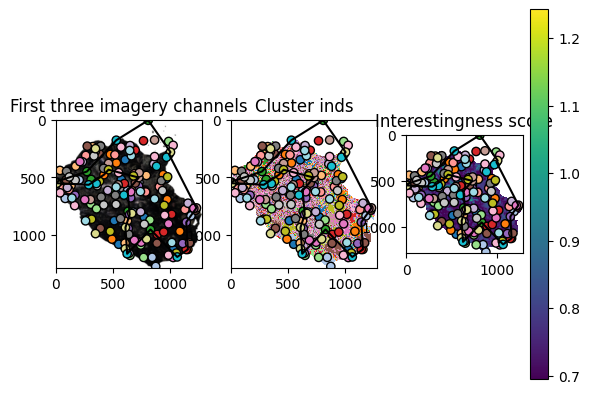

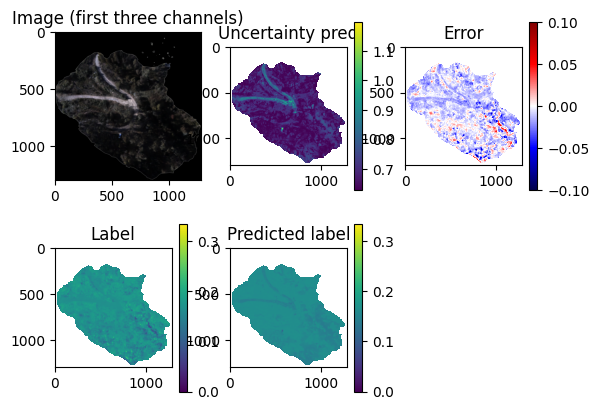

Flight #4


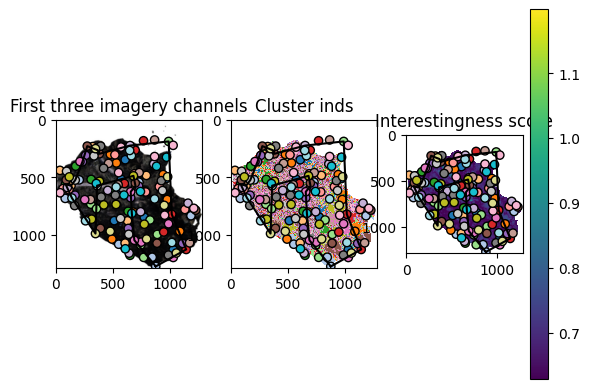

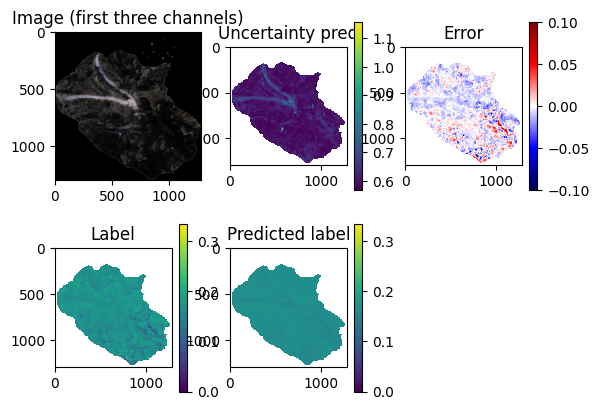

In [ ]:
planner = BatchDiversityPlanner(data, n_candidate_locations=200)
gp = GaussianProcessRegression()
predictor = UncertainMaskedLabeledImagePredictor(
    data, gp, classification_task=data.is_classification_dataset()
)

print("Flight 1")
plan = planner.plan(visit_n_locations=20)
values = data.sample_batch(plan)
predictor.update_model(plan, values)
prediction = predictor.predict_values_and_uncertainty()
visualize_prediction(data, prediction=prediction, predictor=predictor)

for i in range(3):
    print(f"Flight #{i+2}")
    interestingness_image = prediction[UNCERTAINTY_KEY]
    plan = planner.plan(interestingness_image=interestingness_image, visit_n_locations=20)
    values = data.sample_batch(plan)
    predictor.update_model(plan, values)
    prediction = predictor.predict_values_and_uncertainty()
    visualize_prediction(data, prediction=prediction, predictor=predictor)